In [ ]:
from google.colab import drive
import os

# Now mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import glob
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import numpy as np
from google.colab import drive

In [ ]:
ADDITIONAL_EPOCHS = 0  # Number of additional epochs to train in this session
BATCH_SIZE = 4
LEARNING_RATE = 0.0002
CHECKPOINT_DIR = "/content/drive/MyDrive/checkpoints"
DATASET_DIR = "/content/drive/MyDrive/DESOBA_Dataset"
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
IMG_SIZE = 256
SAVE_EVERY = 5
LAMBDA_L1 = 20.0

# Ensure checkpoint directory exists
os.makedirs(CHECKPOINT_DIR, exist_ok=True)

# -------------------- DATASET --------------------
class DBOSADataset(Dataset):
    def __init__(self, root_dir):
        self.root_dir = root_dir
        self.input_paths = sorted(glob.glob(os.path.join(self.root_dir, "DeshadowedImage", "*.png")))
        self.shadow_paths = sorted(glob.glob(os.path.join(self.root_dir, "ShadowImage", "*.png")))
        self.mask_paths = sorted(glob.glob(os.path.join(self.root_dir, "ShadowMask", "*.png")))
        self.inst_paths = sorted(glob.glob(os.path.join(self.root_dir, "InstanceMask", "*.png")))

        if not self.input_paths or not self.shadow_paths or not self.mask_paths or not self.inst_paths:
            raise ValueError(f"Empty dataset in {self.root_dir}. Ensure all subfolders contain matching .png files.")

        if not (len(self.input_paths) == len(self.shadow_paths) == len(self.mask_paths) == len(self.inst_paths)):
            raise ValueError(f"Mismatch in number of files.")

        self.transform = transforms.Compose([
            transforms.Resize((IMG_SIZE, IMG_SIZE)),
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
        ])
        self.mask_transform = transforms.Compose([
            transforms.Resize((IMG_SIZE, IMG_SIZE)),
            transforms.ToTensor()
        ])

    def __len__(self):
        return len(self.input_paths)

    def __getitem__(self, idx):
        base_img = Image.open(self.input_paths[idx]).convert("RGB")
        shadow_img = Image.open(self.shadow_paths[idx]).convert("RGB")
        mask_img = Image.open(self.mask_paths[idx]).convert("L")
        inst_img = Image.open(self.inst_paths[idx]).convert("L")

        base = self.transform(base_img)
        shadow = self.transform(shadow_img)
        mask = self.mask_transform(mask_img)
        inst = self.mask_transform(inst_img)

        return base, shadow, mask, inst

In [ ]:
class Generator(nn.Module):
    def __init__(self, in_channels=3):
        super(Generator, self).__init__()
        def conv_block(in_c, out_c, bn=True, activation=True):
            layers = [nn.Conv2d(in_c, out_c, 4, stride=2, padding=1, bias=not bn)]
            if bn:
                layers.append(nn.BatchNorm2d(out_c))
            if activation:
                layers.append(nn.LeakyReLU(0.2, inplace=True))
            return nn.Sequential(*layers)

        def upconv_block(in_c, out_c, bn=True):
            layers = [nn.ConvTranspose2d(in_c, out_c, 4, stride=2, padding=1, bias=not bn)]
            if bn:
                layers.append(nn.BatchNorm2d(out_c))
            layers.append(nn.ReLU(inplace=True))
            return nn.Sequential(*layers)

        self.enc1 = conv_block(in_channels, 64, bn=False)
        self.enc2 = conv_block(64, 128)
        self.enc3 = conv_block(128, 256)
        self.enc4 = conv_block(256, 512)
        self.enc5 = conv_block(512, 512)
        self.dec1 = upconv_block(512, 512)
        self.dec2 = upconv_block(1024, 256)
        self.dec3 = upconv_block(512, 128)
        self.dec4 = upconv_block(256, 64)
        self.shadow_out = nn.Sequential(
            nn.ConvTranspose2d(128, 3, 4, stride=2, padding=1),
            nn.Tanh()
        )
        self.mask_out = nn.Sequential(
            nn.ConvTranspose2d(128, 1, 4, stride=2, padding=1),
            nn.Sigmoid()
        )
        self.inst_out = nn.Sequential(
            nn.ConvTranspose2d(128, 1, 4, stride=2, padding=1),
            nn.Sigmoid()
        )
        self.attention = nn.Sequential(
            nn.Conv2d(512, 512, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        e1 = self.enc1(x)
        e2 = self.enc2(e1)
        e3 = self.enc3(e2)
        e4 = self.enc4(e3)
        e5 = self.enc5(e4)
        attn = self.attention(e5)
        e5 = e5 * attn
        d1 = self.dec1(e5)
        d2 = self.dec2(torch.cat([d1, e4], dim=1))
        d3 = self.dec3(torch.cat([d2, e3], dim=1))
        d4 = self.dec4(torch.cat([d3, e2], dim=1))
        shadow = self.shadow_out(torch.cat([d4, e1], dim=1))
        mask = self.mask_out(torch.cat([d4, e1], dim=1))
        inst = self.inst_out(torch.cat([d4, e1], dim=1))
        return shadow, mask, inst

# -------------------- DISCRIMINATOR MODEL --------------------
class Discriminator(nn.Module):
    def __init__(self, in_channels=8):
        super(Discriminator, self).__init__()
        def disc_block(in_c, out_c, bn=True):
            layers = [nn.Conv2d(in_c, out_c, 4, stride=2, padding=1)]
            if bn:
                layers.append(nn.BatchNorm2d(out_c))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return nn.Sequential(*layers)

        self.model = nn.Sequential(
            disc_block(in_channels, 64, bn=False),
            disc_block(64, 128),
            disc_block(128, 256),
            disc_block(256, 512),
            nn.Conv2d(512, 1, 4, stride=1, padding=0),
            nn.Sigmoid()
        )

    def forward(self, input_img, shadow_img, mask, inst):
        x = torch.cat([input_img, shadow_img, mask, inst], dim=1)
        return self.model(x)

In [ ]:
def train_model(additional_epochs=ADDITIONAL_EPOCHS):
    print("Starting train_model()")
    generator = Generator().to(DEVICE)
    discriminator = Discriminator().to(DEVICE)
    g_optimizer = optim.Adam(generator.parameters(), lr=LEARNING_RATE, betas=(0.5, 0.999))
    d_optimizer = optim.Adam(discriminator.parameters(), lr=LEARNING_RATE, betas=(0.5, 0.999))
    criterion_gan = nn.BCELoss()
    criterion_l1 = nn.L1Loss()

    # Load latest checkpoint with highest epoch number
    checkpoint_files = sorted(glob.glob(os.path.join(CHECKPOINT_DIR, "gan_epoch_*.pt")))
    start_epoch = 0  # Tracks epochs from previous training
    if checkpoint_files:
        # Extract epoch numbers and find the checkpoint with the highest epoch
        max_epoch = -1
        latest_checkpoint = None
        for checkpoint_file in checkpoint_files:
            # Extract epoch number from filename
            epoch_str = os.path.basename(checkpoint_file).split('_')[-1].split('.')[0]
            try:
                epoch_num = int(epoch_str)
                if epoch_num > max_epoch:
                    max_epoch = epoch_num
                    latest_checkpoint = checkpoint_file
            except ValueError:
                continue  # Skip if epoch number is not an integer

        if latest_checkpoint:
            print(f"Loading checkpoint: {latest_checkpoint}")
            try:
                checkpoint = torch.load(latest_checkpoint, map_location=DEVICE)
                generator.load_state_dict(checkpoint["generator_state"])
                discriminator.load_state_dict(checkpoint["discriminator_state"])
                g_optimizer.load_state_dict(checkpoint["g_optimizer_state"])
                d_optimizer.load_state_dict(checkpoint["d_optimizer_state"])
                start_epoch = checkpoint["epoch"] + 1  # Start from the next epoch
                print(f"Resuming from epoch {start_epoch}")
            except Exception as e:
                print(f"Error loading checkpoint: {e}")
                return

    # Calculate total epochs to train (cumulative)
    end_epoch = start_epoch + additional_epochs

    # Load dataset
    try:
        dataset = DBOSADataset(DATASET_DIR)
        print(f"Dataset loaded successfully: {len(dataset)} samples")
    except Exception as e:
        print(f"Error loading dataset: {e}")
        return

    train_size = int(0.8 * len(dataset))
    val_size = len(dataset) - train_size
    if train_size == 0 or val_size == 0:
        print(f"Dataset size too small: {len(dataset)} samples.")
        return
    train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])
    print(f"Training dataset size: {len(train_dataset)}")
    print(f"Validation dataset size: {len(val_dataset)}")

    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

    real_label = torch.ones(BATCH_SIZE, 1, 13, 13).to(DEVICE)
    fake_label = torch.zeros(BATCH_SIZE, 1, 13, 13).to(DEVICE)

    for epoch in range(start_epoch, end_epoch):
        generator.train()
        discriminator.train()
        train_g_loss = 0.0
        train_d_loss = 0.0
        train_l1_loss = 0.0

        for batch in train_loader:
            inputs, real_shadow, real_mask, real_inst = batch
            inputs, real_shadow, real_mask, real_inst = inputs.to(DEVICE), real_shadow.to(DEVICE), real_mask.to(DEVICE), real_inst.to(DEVICE)

            d_optimizer.zero_grad()
            real_output = discriminator(inputs, real_shadow, real_mask, real_inst)
            d_loss_real = criterion_gan(real_output, real_label[:real_output.size(0)])
            fake_shadow, fake_mask, fake_inst = generator(inputs)
            fake_output = discriminator(inputs, fake_shadow, fake_mask, fake_inst)
            d_loss_fake = criterion_gan(fake_output, fake_label[:fake_output.size(0)])
            d_loss = (d_loss_real + d_loss_fake) * 0.5
            d_loss.backward()
            d_optimizer.step()

            g_optimizer.zero_grad()
            fake_shadow, fake_mask, fake_inst = generator(inputs)
            fake_output = discriminator(inputs, fake_shadow, fake_mask, fake_inst)
            g_loss_gan = criterion_gan(fake_output, real_label[:fake_output.size(0)])
            g_loss_l1_shadow = criterion_l1(fake_shadow, real_shadow)
            g_loss_l1_mask = criterion_l1(fake_mask, real_mask)
            g_loss_l1_inst = criterion_l1(fake_inst, real_inst)
            g_loss_l1 = g_loss_l1_shadow + g_loss_l1_mask + g_loss_l1_inst
            g_loss = g_loss_gan + LAMBDA_L1 * g_loss_l1
            g_loss.backward()
            g_optimizer.step()

            train_g_loss += g_loss.item()
            train_d_loss += d_loss.item()
            train_l1_loss += g_loss_l1.item()

        generator.eval()
        discriminator.eval()
        val_g_loss = 0.0
        val_d_loss = 0.0
        val_l1_loss = 0.0
        with torch.no_grad():
            for batch in val_loader:
                inputs, real_shadow, real_mask, real_inst = batch
                inputs, real_shadow, real_mask, real_inst = inputs.to(DEVICE), real_shadow.to(DEVICE), real_mask.to(DEVICE), real_inst.to(DEVICE)
                real_output = discriminator(inputs, real_shadow, real_mask, real_inst)
                d_loss_real = criterion_gan(real_output, real_label[:real_output.size(0)])
                fake_shadow, fake_mask, fake_inst = generator(inputs)
                fake_output = discriminator(inputs, fake_shadow, fake_mask, fake_inst)
                d_loss_fake = criterion_gan(fake_output, fake_label[:fake_output.size(0)])
                d_loss = (d_loss_real + d_loss_fake) * 0.5
                g_loss_gan = criterion_gan(fake_output, real_label[:fake_output.size(0)])
                g_loss_l1_shadow = criterion_l1(fake_shadow, real_shadow)
                g_loss_l1_mask = criterion_l1(fake_mask, real_mask)
                g_loss_l1_inst = criterion_l1(fake_inst, real_inst)
                g_loss_l1 = g_loss_l1_shadow + g_loss_l1_mask + g_loss_l1_inst
                g_loss = g_loss_gan + LAMBDA_L1 * g_loss_l1
                val_g_loss += g_loss.item()
                val_d_loss += d_loss.item()
                val_l1_loss += g_loss_l1.item()

        train_g_loss = train_g_loss / len(train_loader)
        train_d_loss = train_d_loss / len(train_loader)
        train_l1_loss = train_l1_loss / len(train_loader)
        val_g_loss = val_g_loss / len(val_loader)
        val_d_loss = val_d_loss / len(val_loader)
        val_l1_loss = val_l1_loss / len(val_loader)

        print(f"Epoch [{epoch+1}/{end_epoch}], "
              f"Train G Loss: {train_g_loss:.4f}, Train D Loss: {train_d_loss:.4f}, Train L1 Loss: {train_l1_loss:.4f}, "
              f"Val G Loss: {val_g_loss:.4f}, Val D Loss: {val_d_loss:.4f}, Val L1 Loss: {val_l1_loss:.4f}")

        if (epoch + 1) % SAVE_EVERY == 0:
            ckpt_path = os.path.join(CHECKPOINT_DIR, f"gan_epoch_{epoch+1}.pt")
            torch.save({
                "epoch": epoch,  # Save cumulative epoch
                "generator_state": generator.state_dict(),
                "discriminator_state": discriminator.state_dict(),
                "g_optimizer_state": g_optimizer.state_dict(),
                "d_optimizer_state": d_optimizer.state_dict()
            }, ckpt_path)
            print(f"Saved checkpoint to {ckpt_path}")

In [ ]:
if __name__ == '__main__':
    if not os.path.exists('/content/drive'):
        drive.mount('/content/drive')
    else:
        print("Google Drive already mounted")

    print("Starting training...")
    train_model(additional_epochs=ADDITIONAL_EPOCHS)

Google Drive already mounted
Starting training...
Starting train_model()
Loading checkpoint: /content/drive/MyDrive/checkpoints/gan_epoch_1000.pt
Resuming from epoch 1000
Dataset loaded successfully: 1012 samples
Training dataset size: 809
Validation dataset size: 203


Google Drive already mounted at /content/drive
Using checkpoint: /content/drive/MyDrive/checkpoints/gan_epoch_1000.pt (epoch 1000)
Please upload your deshadowed image (any format: .png, .jpg, .jpeg, .bmp)


Saving Screenshot 2025-07-17 111902.png to Screenshot 2025-07-17 111902.png


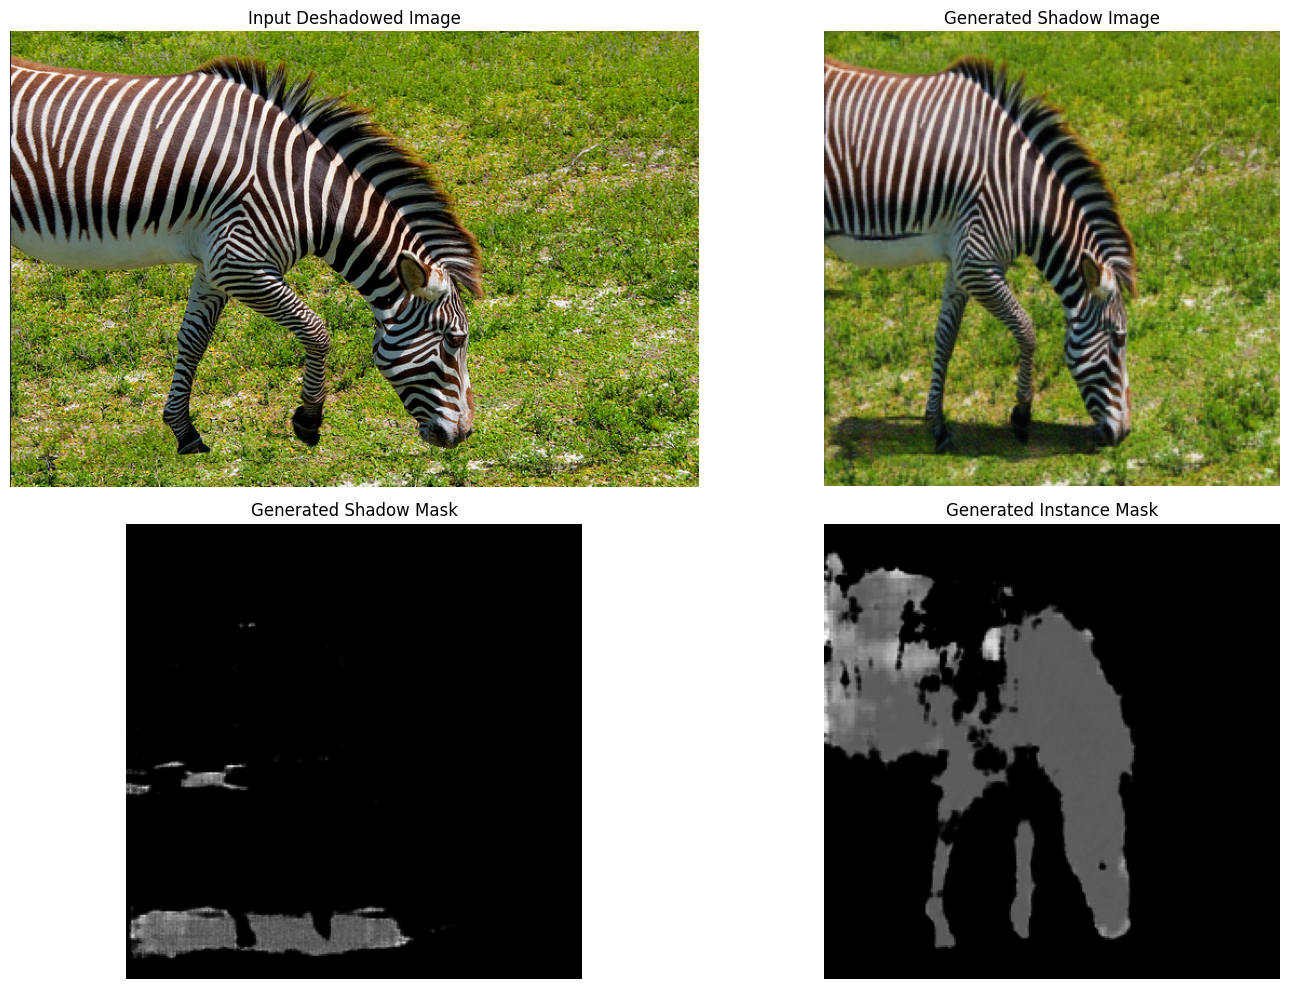

In [ ]:
import os
import glob
import torch
import torch.nn as nn
from torchvision import transforms
from PIL import Image
import numpy as np
from google.colab import files
import matplotlib.pyplot as plt
import re

# -------------------- CONFIG --------------------
CHECKPOINT_DIR = "/content/drive/MyDrive/checkpoints"
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
IMG_SIZE = 256

# -------------------- GENERATOR MODEL --------------------
class Generator(nn.Module):
    def __init__(self, in_channels=3):
        super(Generator, self).__init__()

        def conv_block(in_c, out_c, bn=True, activation=True):
            layers = [nn.Conv2d(in_c, out_c, 4, stride=2, padding=1, bias=not bn)]
            if bn:
                layers.append(nn.BatchNorm2d(out_c))
            if activation:
                layers.append(nn.LeakyReLU(0.2, inplace=True))
            return nn.Sequential(*layers)

        def upconv_block(in_c, out_c, bn=True):
            layers = [nn.ConvTranspose2d(in_c, out_c, 4, stride=2, padding=1, bias=not bn)]
            if bn:
                layers.append(nn.BatchNorm2d(out_c))
            layers.append(nn.ReLU(inplace=True))
            return nn.Sequential(*layers)

        # Encoder
        self.enc1 = conv_block(in_channels, 64, bn=False)
        self.enc2 = conv_block(64, 128)
        self.enc3 = conv_block(128, 256)
        self.enc4 = conv_block(256, 512)
        self.enc5 = conv_block(512, 512)

        # Decoder with skip connections
        self.dec1 = upconv_block(512, 512)
        self.dec2 = upconv_block(1024, 256)  # 512 (dec1) + 512 (enc4)
        self.dec3 = upconv_block(512, 128)   # 256 (dec2) + 256 (enc3)
        self.dec4 = upconv_block(256, 64)    # 128 (dec3) + 128 (enc2)

        # Output heads
        self.shadow_out = nn.Sequential(
            nn.ConvTranspose2d(128, 3, 4, stride=2, padding=1),  # 64 (dec4) + 64 (enc1)
            nn.Tanh()
        )
        self.mask_out = nn.Sequential(
            nn.ConvTranspose2d(128, 1, 4, stride=2, padding=1),
            nn.Sigmoid()  # Shadow mask (0 to 1)
        )
        self.inst_out = nn.Sequential(
            nn.ConvTranspose2d(128, 1, 4, stride=2, padding=1),
            nn.Sigmoid()  # Instance mask (0 to 1)
        )

        # Attention mechanism
        self.attention = nn.Sequential(
            nn.Conv2d(512, 512, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        # Encoder
        e1 = self.enc1(x)
        e2 = self.enc2(e1)
        e3 = self.enc3(e2)
        e4 = self.enc4(e3)
        e5 = self.enc5(e4)

        # Attention
        attn = self.attention(e5)
        e5 = e5 * attn

        # Decoder with skip connections
        d1 = self.dec1(e5)
        d2 = self.dec2(torch.cat([d1, e4], dim=1))
        d3 = self.dec3(torch.cat([d2, e3], dim=1))
        d4 = self.dec4(torch.cat([d3, e2], dim=1))

        # Outputs
        shadow = self.shadow_out(torch.cat([d4, e1], dim=1))
        mask = self.mask_out(torch.cat([d4, e1], dim=1))
        inst = self.inst_out(torch.cat([d4, e1], dim=1))

        return shadow, mask, inst

# -------------------- INFERENCE --------------------
def generate_outputs(image_path, model_path):
    # Initialize model and load checkpoint
    model = Generator().to(DEVICE)
    checkpoint = torch.load(model_path, map_location=DEVICE)
    model.load_state_dict(checkpoint["generator_state"])
    model.eval()

    # Define transformations
    transform = transforms.Compose([
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    ])

    # Load and preprocess input (support any PIL-compatible format)
    try:
        input_img = Image.open(image_path).convert("RGB")
    except Exception as e:
        raise ValueError(f"Failed to load image: {e}. Ensure file is a valid image (e.g., .png, .jpg, .jpeg, .bmp).")

    input_tensor = transform(input_img).unsqueeze(0).to(DEVICE)  # [1, 3, 256, 256]

    # Generate outputs
    with torch.no_grad():
        shadow, mask, inst = model(input_tensor)

    # Post-process outputs
    shadow = shadow.squeeze().cpu().numpy().transpose(1, 2, 0)
    shadow = (shadow * 0.5 + 0.5) * 255.0  # Denormalize
    shadow = np.clip(shadow, 0, 255).astype(np.uint8)

    mask = mask.squeeze().cpu().numpy() * 255.0  # Scale to 0-255
    mask = np.clip(mask, 0, 255).astype(np.uint8)

    inst = inst.squeeze().cpu().numpy() * 255.0  # Scale to 0-255
    inst = np.clip(inst, 0, 255).astype(np.uint8)

    return input_img, shadow, mask, inst

# -------------------- RUN --------------------
if __name__ == '__main__':
    # Mount Google Drive if not already mounted
    if not os.path.exists('/content/drive'):
        from google.colab import drive
        drive.mount('/content/drive')
    else:
        print("Google Drive already mounted at /content/drive")

    # Find latest checkpoint by highest epoch number
    checkpoint_files = glob.glob(os.path.join(CHECKPOINT_DIR, "gan_epoch_*.pt"))
    if not checkpoint_files:
        print("No checkpoints found in", CHECKPOINT_DIR)
        exit()

    # Extract epoch numbers and select the highest
    def get_epoch_number(filename):
        match = re.search(r'gan_epoch_(\d+).pt', os.path.basename(filename))
        return int(match.group(1)) if match else -1

    checkpoint_files = [(f, get_epoch_number(f)) for f in checkpoint_files]
    checkpoint_files = [(f, e) for f, e in checkpoint_files if e != -1]  # Filter out invalid filenames
    if not checkpoint_files:
        print("No valid checkpoint files found with format 'gan_epoch_<number>.pt'")
        exit()

    latest_checkpoint, latest_epoch = max(checkpoint_files, key=lambda x: x[1])
    print(f"Using checkpoint: {latest_checkpoint} (epoch {latest_epoch})")

    # Upload deshadowed image
    print("Please upload your deshadowed image (any format: .png, .jpg, .jpeg, .bmp)")
    uploaded = files.upload()

    if len(uploaded) != 1:
        print("Error: Please upload exactly one deshadowed image")
        exit()

    # Get file path
    image_path = list(uploaded.keys())[0]

    # Generate outputs
    try:
        input_img, shadow_img, shadow_mask, inst_mask = generate_outputs(image_path, latest_checkpoint)

        # Display results
        plt.figure(figsize=(15, 10))

        plt.subplot(2, 2, 1)
        plt.title("Input Deshadowed Image")
        plt.imshow(input_img)
        plt.axis('off')

        plt.subplot(2, 2, 2)
        plt.title("Generated Shadow Image")
        plt.imshow(shadow_img)
        plt.axis('off')

        plt.subplot(2, 2, 3)
        plt.title("Generated Shadow Mask")
        plt.imshow(shadow_mask, cmap='gray')
        plt.axis('off')

        plt.subplot(2, 2, 4)
        plt.title("Generated Instance Mask")
        plt.imshow(inst_mask, cmap='gray')
        plt.axis('off')

        plt.tight_layout()
        plt.show()

        # Save outputs
        #Image.fromarray(shadow_img).save("generated_shadow.png")
        #Image.fromarray(shadow_mask).save("generated_shadow_mask.png")
        #Image.fromarray(inst_mask).save("generated_instance_mask.png")
        #print("Outputs saved as 'generated_shadow.png', 'generated_shadow_mask.png', and 'generated_instance_mask.png'")

    except Exception as e:
        print(f"Error during inference: {e}")